# Music Generation Using RNN

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import music21 as m21

from tqdm.notebook import tqdm
from pathlib import Path
%matplotlib inline

In [2]:
print(tf.__version__)

2.6.0


## Prepare DataSet

In [3]:
!wget https://www.dropbox.com/s/n8ovgqivgzpxkla/carol_melodies.pkl?dl=1 -O carol_melodies.pkl -o /dev/null

In [4]:
import pickle
# this pieces are 4/4, transposed to C and trimmed empty measures
# but they contain every range (octave) so they should be filtered (e.g. pick treble clef only)
songs = pickle.load(open("carol_melodies.pkl", "rb")) # we will work only with 4/4 pieces
len(songs)

2433

### Filter dataset

In [5]:
 def treble_best_fit(seq):
    P = lambda x: m21.pitch.Pitch(x).midi
    def compensate_note(note):
        if note > P("A4"):
            return note + 3
        if note < P("F3"):
            return note - 3
        return note
    notes = [x[0] for x in seq if x[0] is not None]
    mid = np.mean(notes)
    return mid > P("B3") and mid < P("E5")

In [6]:
selected_songs = [x for x in songs if treble_best_fit(x) and len(x) < 100 and len(x) > 20]
len(selected_songs)

968

### Some analysis on filtered data

In [7]:
pitches = sorted(set([note[0] for song in selected_songs for note in song if note[0] is not None]))
print("N. of pitches:", len(pitches))
print("lowest: ", pitches[0], m21.pitch.Pitch(midi=pitches[0]))
print("highest:", pitches[-1], m21.pitch.Pitch(midi=pitches[-1]))

N. of pitches: 33
lowest:  48 C3
highest: 83 B5


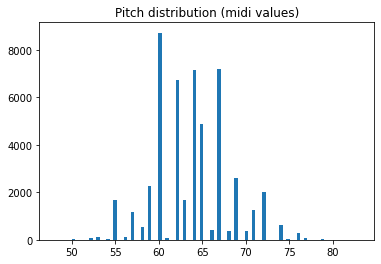

In [8]:
plt.hist([note[0] for song in selected_songs for note in song if note[0] is not None], bins=88);
plt.title("Pitch distribution (midi values)");

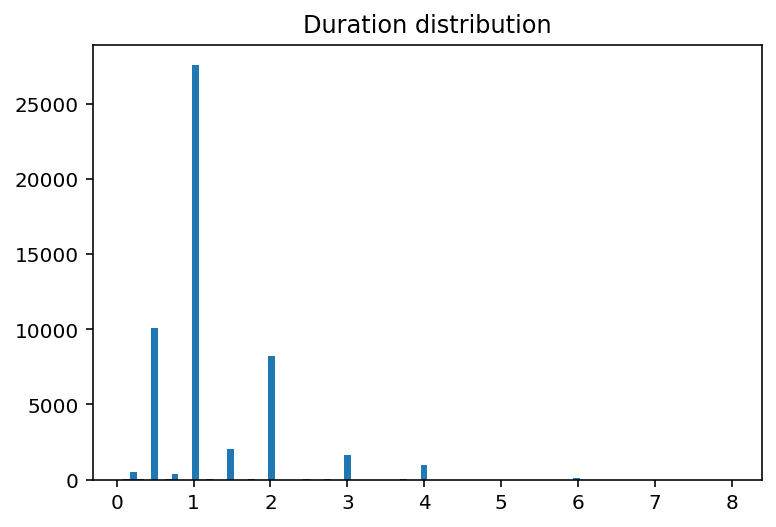

In [9]:
plt.hist([float(note[1]) for song in selected_songs for note in song], bins=88);
plt.title("Duration distribution");

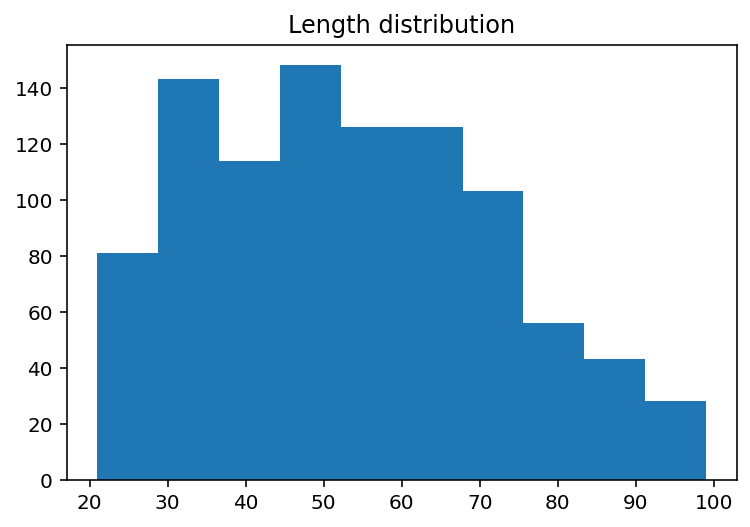

In [10]:
plt.hist([len(song) for song in selected_songs]);
plt.title("Length distribution");

### Vectorization

In [11]:
pitch_vocab = sorted(set((note[0] for song in selected_songs for note in song)), key=lambda x: -1 if x is None else x)
dur_vocab = sorted(set((note[1] for song in selected_songs for note in song)))
pitch_inverse_vocab = {v:i+1 for i,v in enumerate(pitch_vocab)} # shift is because "0" means padding
dur_inverse_vocab = {v:i+1 for i,v in enumerate(dur_vocab)} # shift is because "0" means padding
print(f"Unique elements in vocabulary:\npitches {len(pitch_vocab)}\ndurations {len(dur_vocab)}")

def vec2mus(vec):
    note_spec = [(pitch_vocab[i-1], dur_vocab[j-1]) for i,j in vec] # shift is because "0" means padding
    stream = m21.stream.Stream()
    for pitch, dur in note_spec:
        if pitch is not None:
            note = note = m21.note.Note(midi=pitch, quarterLength=dur)
        else:
            note = m21.note.Rest(quarterLength=dur)
        stream.append(note)
    return stream

def notespec2vec(note_spec):
    return np.array([[pitch_inverse_vocab[p], dur_inverse_vocab[d]] for p,d in note_spec], dtype=int)

vec_songs = tf.ragged.constant([notespec2vec(song) for song in selected_songs], inner_shape=(2,))
print(vec_songs.shape)

Unique elements in vocabulary:
pitches 34
durations 29
(968, None, 2)


In [12]:
vec2mus(vec_songs[-27]).write("midi", fp="in.midi") # not working.. why??

'in.midi'

Training and target data:

In [13]:
X = tf.unstack(vec_songs[:, :-1, :].to_tensor(default_value=0), axis=-1)
y = tf.unstack(vec_songs[:, 1:, :].to_tensor(default_value=0), axis=-1)

In [14]:
print(X[0].shape)
print(y[1].shape)

(968, 98)
(968, 98)


## Train Model

Model definition

In [15]:
def build_model(rnn_units, filters, kernel_size, pitch_vocab_size, dur_vocab_size, emb_dim=64, batch_size=64):
    inp_p = tf.keras.layers.Input(shape=(None,), name="input_pitch")
    inp_d = tf.keras.layers.Input(shape=(None,), name="input_duration")
    emb_p = tf.keras.layers.Embedding(pitch_vocab_size+1, emb_dim, mask_zero=True)(inp_p)
    emb_d = tf.keras.layers.Embedding(dur_vocab_size+1, emb_dim, mask_zero=True)(inp_d)
    #conv_p = tf.keras.layers.Conv1D(filters, kernel_size, padding="causal")
    #conv_d = tf.keras.layers.Conv1D(filters, kernel_size, padding="causal")
    #conv_p.supports_https://bugs.telegram.org/masking = True
    #conv_d.supports_masking = True
    all_feats = tf.keras.layers.concatenate([emb_p, emb_d])
    lstm = tf.keras.layers.LSTM(
        rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        #stateful=True,
    )(all_feats)
    dense_pitch = tf.keras.layers.Dense(pitch_vocab_size+1, name="pitch")(lstm)
    dense_dur = tf.keras.layers.Dense(dur_vocab_size+1, name="duration")(lstm)
    return tf.keras.Model(inputs=[inp_p, inp_d], outputs=[dense_pitch, dense_dur])

Training parameters

In [16]:
# Optimization parameters:
num_training_iterations = 100  # Increase this to train longer
batch_size = 64  # Experiment between 1 and 64
learning_rate = 5e-3 # Experiment between 1e-5 and 1e-1

# Model parameters:
rnn_units = 1024 # Experiment between 1 and 2048
filters = 32
kernel_size = 4
emb_dim = 512

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt_w")

build_model(rnn_units, filters, kernel_size, len(pitch_vocab), len(dur_vocab), emb_dim, None).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_pitch (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
input_duration (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    17920       input_pitch[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    15360       input_duration[0][0]             
______________________________________________________________________________________________

Train model

In [17]:
from IPython.display import clear_output

class HistoryPlotter(tf.keras.callbacks.Callback):
    def __init__(self, each_epoch=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logs = []
        self.each_epoch = each_epoch
    def on_epoch_end(self, epoch, logs):
        self.logs.append(logs)
        if epoch % self.each_epoch == 0:
            clear_output()
            print(f"-- Epoch {epoch}")
            plt.figure(figsize=(12,5))
            plt.subplot(121)
            plt.plot([(l["pitch_loss"], l["duration_loss"]) for l in self.logs])
            plt.legend(labels=("pitch", "duration"))
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.subplot(122)
            plt.plot([(l["pitch_acc"], l["duration_acc"]) for l in self.logs])
            plt.legend(labels=("pitch", "duration"))
            plt.xlabel("Iterations")
            plt.ylabel("Accuracy")
            plt.show()

-- Epoch 35


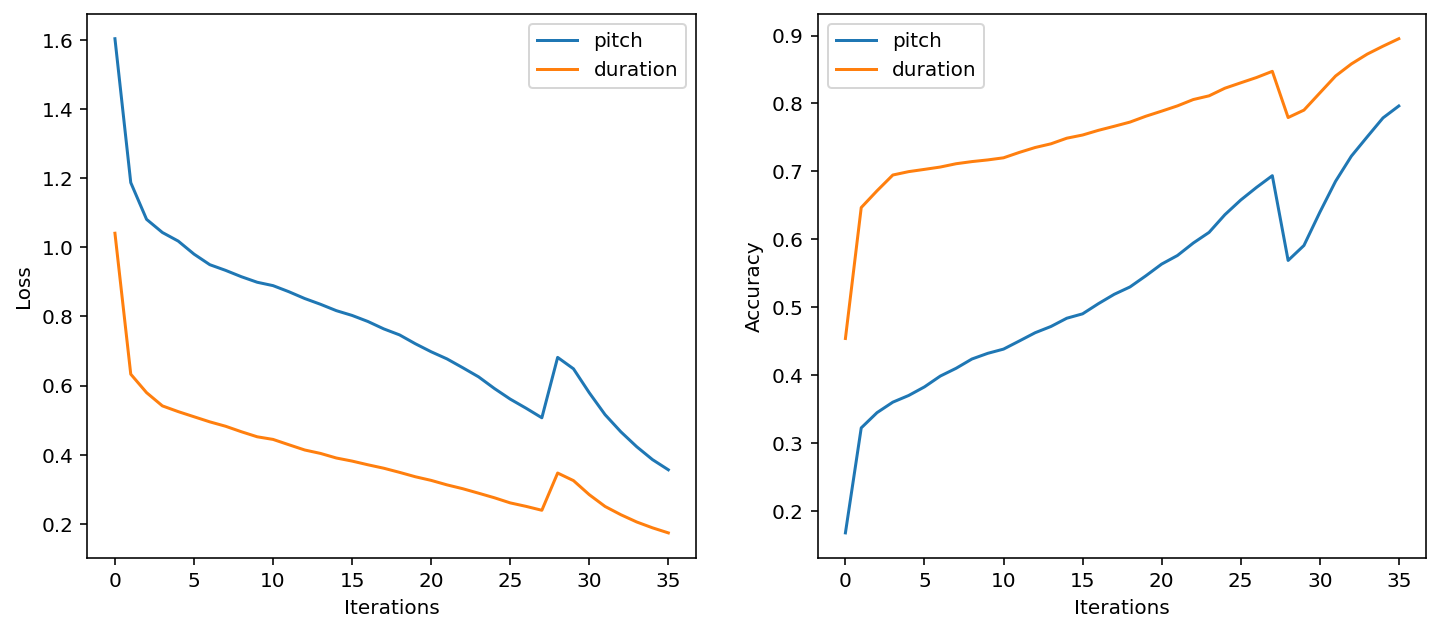

In [ ]:
model = build_model(rnn_units, filters, kernel_size, len(pitch_vocab), len(dur_vocab), emb_dim, None)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
);

model.fit(
    X, y,
    epochs = num_training_iterations,
    verbose = 0,
    batch_size = batch_size,
    callbacks = [
        HistoryPlotter(),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_prefix, monitor="loss", save_best_only=True, save_weights_only=True),
    ]
);

## Try to generate something

Reload model

In [ ]:
model_gen = build_model(rnn_units, filters, kernel_size, len(pitch_vocab), len(dur_vocab), emb_dim, batch_size=None)
model_gen.load_weights(checkpoint_prefix).expect_partial()
model_gen.summary()

generate function

In [ ]:
def generate_noteseq(model, start_vec=[[2,3]], generation_max_length=1000):
    input_eval = tf.expand_dims(start_vec, 0)

    generated = list(start_vec)
    model.reset_states()

    for i in tqdm(range(generation_max_length)):
        p_pred, d_pred = model(tf.unstack(input_eval, axis=-1))
        p_id = tf.random.categorical(p_pred[0], num_samples=1)[-1, 0].numpy()
        d_id = tf.random.categorical(d_pred[0], num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([[p_id, d_id]], 0)
        if p_id != 0 and d_id != 0:
            generated.append([p_id, d_id])
        else:
            print("padding... skip")
            if p_id != d_id:
                print("Pitch and duration don't agree on zero... interesting")
        
    
    return np.array(generated)

generate something and playback

In [ ]:
from IPython import display as ipythondisplay

start_vec = tf.stack(X, axis=-1)[np.random.randint(0, len(X)), :1]
#start_vec = np.random.randint(0, len(vocab), size=(4,))
generated_vec = generate_noteseq(model_gen, start_vec=start_vec, generation_max_length=30)

In [ ]:
### Play back generated songs ###
vec2mus(generated_vec).write("midi", fp="hello.mid")

-----

What we need to do:
1. **dataset preparation**:
  - ✅ remove pieces that are not 4/4
  - ✅ transpose everything to C
  - ✅ remove chords
  - ✅ treat voices as distinct music pieces
  - ✅ vectorize to `(pitch, duration)`
2. **model**:
  - use a 1D conv layer to detect melodic inflections
  - ✅ use SLTM layer to learn long-term features
  - ✅ train model using variable-length pieces (don't concatenate everything!)
3. **generation**:
  - generate several music pieces and pick only the interesting ones
  - save generated pieces for interaction part (pre-generated music)

### Save model for tfjs

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model_gen, "tfjs/")

In [ ]:
!zip -r tfjs.zip tfjs

In [ ]:
pitch_vocab

In [ ]:
dur_vocab

In [ ]:
print(vec_songs[:, :1])